# Characterization of forecast performance

Here we compute the ROC curve from different features.

## Import libraries

In [1]:
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import feather
from sklearn.metrics import roc_curve, auc

## Load the data from GLM results

Here we have the results of the GLM model (see forecasting notebook see previously) using the seizure or IEA timeseries as covariates.

The columns of interest here are: 
   - patient: the name of the patient
   - preds_test: the forecasted values on the test dataset
   - test_Sz: if there is a seizure or not happening at that particular time point
   - cov_choice: the name of the covariate used for that prediction

In [2]:
results = feather.read_dataframe(r'data/all_patients_ts_test_day_acausal4.feather')
results = results[~results['score_method'].isna()] # we remove a few Nan lines
results[['patient', 'preds_test', 'test_Sz', 'cov_choice']]

,patient,preds_test,test_Sz,cov_choice
1,BJ,0.127896,0.0,only_cross
2,BJ,0.229434,0.0,only_cross
3,BJ,0.371381,0.0,only_cross
4,BJ,0.099135,1.0,only_cross
5,BJ,0.093314,0.0,only_cross
...,...,...,...,...
8382,WP,0.262944,0.0,only_auto
8383,WP,0.337132,0.0,only_auto
8384,WP,0.387617,0.0,only_auto
8385,WP,0.387617,1.0,only_auto


We select forecasts for patient JE and for those two covariates

In [3]:
patient = "JE"
predictions_sz = results[(results['patient']==patient) & 
                         (results['cov_choice']=='only_auto')]['preds_test'].to_numpy()
predictions_IEA = results[(results['patient']==patient) & 
                          (results['cov_choice']=='only_cross')]['preds_test'].to_numpy()

We also select the seizures, which are the same for the two covariates.

In [4]:
seizures = results[(results['patient']==patient) & (results['cov_choice']=='only_cross')]['test_Sz'].to_numpy().astype('int')

## Visualization of the results

Plot the covariates with the seizures

Visually, IEA seems to  perform better. Can we quantify this observation to confirm our intuition?

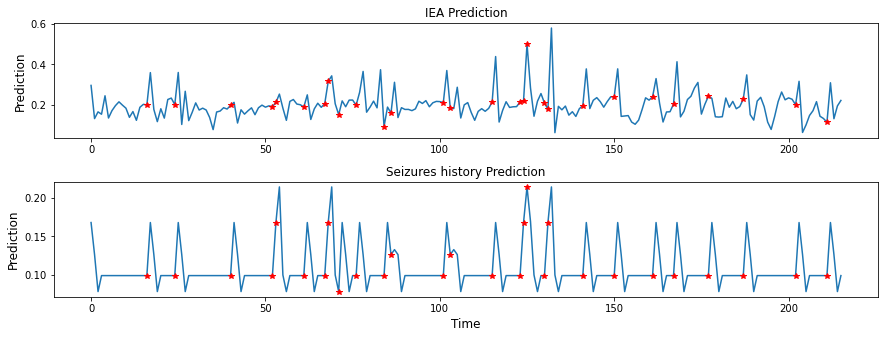

In [5]:
fig, axs = plt.subplots(2, 1,figsize=(12.4, 4.8))
axs[0].set_ylabel('Prediction',fontsize=12)
axs[0].plot(predictions_IEA)
axs[0].plot(np.nonzero(seizures)[0],predictions_IEA[seizures==1],'r*')
axs[0].set_title('IEA Prediction')
axs[1].set_title('Seizures history Prediction')
axs[1].plot(predictions_sz)
axs[1].plot(np.nonzero(seizures)[0],predictions_sz[seizures==1],'r*')
axs[1].set_xlabel('Time',fontsize=12)
axs[1].set_ylabel('Prediction',fontsize=12)
plt.tight_layout()
plt.show();

## Receiver operating characteristics (ROC) curve

To quantify how well our forecast is performing, we will compute the receiver operating characterics (ROC) curve. To do so, we first need to compute:
   - Sensitivity (or true positive rate, TPR), which corresponds to the proportion of seizures correctly identified.
   - Specificity, which is the proportion of non seizures days correctly identified. We will then use 1 - specificity, i.e. the false positive rate (FPR)
   
We will directly use the scikit-learn library, that already implements those metrics.

In [6]:
fpr_IEA, tpr_IEA, thresholds_keras = roc_curve(seizures, predictions_IEA)
fpr_sz, tpr_sz, thresholds_keras = roc_curve(seizures, predictions_sz)

### Plotting the ROC curve

We can then plot the ROC curve, by plotting the sensitivity on the y-axis, versus 1 - specificity on the x-axis:

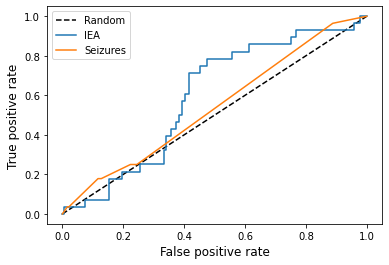

In [7]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_IEA, tpr_IEA)
plt.plot(fpr_sz, tpr_sz)
plt.xlabel('False positive rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.legend(['Random','IEA' ,'Seizures'])
plt.show();

The diagonal dashed line corresponds to a random forecast.

### Area under the ROC Curve

The ROC curve allows us to visualize the trade-off between sensitivity (TPR) and specificity (FPR). To quantify this trade-off, we can compute the area under the ROC curve (AUROC), which is a single quantitiy that tells us how good or bad our classification is.  

   - For AUROC = 0.5, the forecast is random.
   - For AUROC = 1, the forecast is perfect, i.e. it can perfectly separate the Seizures and non seizures days.


In [8]:
auroc_IEA = auc(fpr_IEA, tpr_IEA)
auroc_sz = auc(fpr_sz, tpr_sz)
print('Auroc using the IEA model of prediction = %0.2f' % auroc_IEA)
print('Auroc using the seizure history model of prediction = %0.2f' % auroc_sz)

Auroc using the IEA model of prediction = 0.59
Auroc using the seizure history model of prediction = 0.54


The AUROC can be visualized as the area under each of the ROC curves.

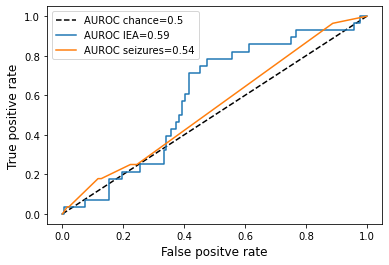

In [9]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_IEA, tpr_IEA,label='Keras (area = {:.3f})'.format(auroc_IEA))
plt.plot(fpr_sz, tpr_sz, label='Keras (area = {:.3f})'.format(auroc_sz))
plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.legend(['AUROC chance=0.5','AUROC IEA=%0.2f' %(auroc_IEA),'AUROC seizures=%0.2f' %(auroc_sz)])
plt.show();

Here, we see that the IEA is better than the history of seizures as a predictor. Still, the values are close to 0.5, thus the classification is not very good.

## Using Multidien cycles for prediction
We will now use the results of the GLM model using the Multidien phase (cos(phase) + sin(phase)) as a covariates and evaluate the performance when accounting for the phase of these cycles as a predictor. 

In [10]:
results_multi = feather.read_dataframe(r'data/all_patients_no_cross_auto_ts_test_day_acausal4.feather')
results_multi = results_multi[~results_multi['score_method'].isna()] # we remove a few Nan lines
results = pd.concat([results, results_multi])
results_multi[['patient', 'preds_test', 'test_Sz', 'cov_choice']]

,patient,preds_test,test_Sz,cov_choice
1,BJ,0.140870,0.0,week_hist
2,BJ,0.119790,0.0,week_hist
3,BJ,0.121372,0.0,week_hist
4,BJ,0.144757,0.0,week_hist
5,BJ,0.130533,0.0,week_hist
...,...,...,...,...
8454,WP,0.707840,0.0,phase_multi
8455,WP,0.708469,0.0,phase_multi
8456,WP,0.611408,0.0,phase_multi
8457,WP,0.465036,1.0,phase_multi


We perform the same displays and performance evaluation as before, but now taking the prediction of the GLM model based on the multidien phase.

In [11]:
predictions_multi = results[(results['patient']==patient) & 
                         (results['cov_choice']=='phase_multi')]['preds_test'].to_numpy()[2:]

We plot the predictions with the corresponding seizures

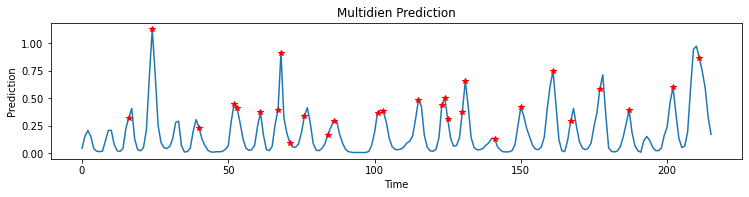

In [12]:
fig, axs = plt.subplots(1, 1,figsize=(12.4, 2.5))
plt.plot(predictions_multi)
plt.plot(np.nonzero(seizures)[0], predictions_multi[seizures==1],'r*')
plt.title('Multidien Prediction')
plt.xlabel('Time')
plt.ylabel('Prediction')
plt.show();

We compute the FPR and TPR, and the area under the curve.

In [13]:
fpr_multi, tpr_multi, thresholds_keras = roc_curve(seizures, predictions_multi)
auroc_multi = auc(fpr_multi, tpr_multi)
auroc_multi

0.8890577507598784

We can now plot the ROC curve for the multidien prediction along with the others covariates

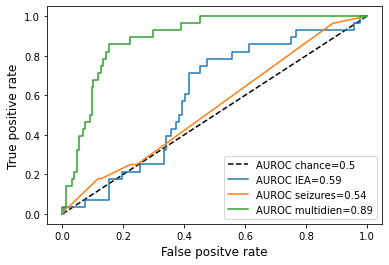

In [14]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_IEA, tpr_IEA)
plt.plot(fpr_sz, tpr_sz)
plt.plot(fpr_multi, tpr_multi)

plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.legend(['AUROC chance=0.5','AUROC IEA=%0.2f' %(auroc_IEA),'AUROC seizures=%0.2f' %(auroc_sz),'AUROC multidien=%0.2f' %(auroc_multi)])
plt.show();

We now cleary see that the multidien phase is a much better predictor than both the IEA or the seizure history for this patient.

## Surrogate predictions

We just saw that for the IEA and the seizure history, the AUROC are very close to the random behavior. To see if these covariates are nevertheless weak predictors or not, we will now compare their AUROC's results with that of surrogate timeseries. To do so, we randomly permutate predictions and compute the AUROC of the shuffled time series. This permutation can only result in prediction by chance, but the chance-level might be slightly different from 0.5.

In [15]:
predictions_IEA_surro = np.random.permutation(predictions_IEA)
predictions_sz_surro = np.random.permutation(predictions_sz)

Plot the surrogates of the IEA with the real prediction.

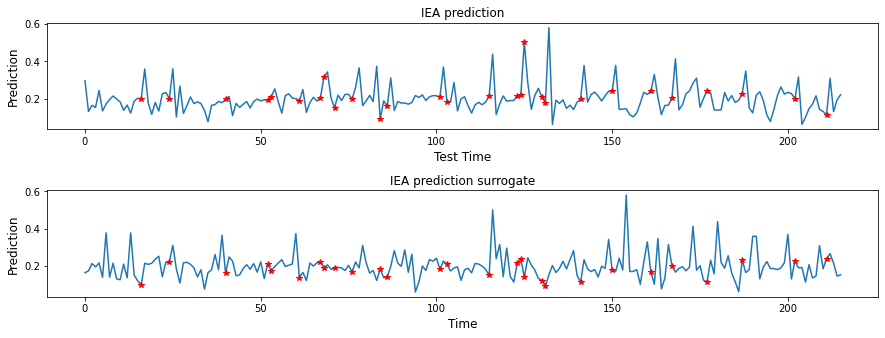

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(12.4, 4.8))
axs[0].set_xlabel('Test Time',fontsize=12)
axs[0].set_ylabel('Prediction',fontsize=12)
axs[0].plot(predictions_IEA)
axs[0].plot(np.nonzero(seizures)[0], predictions_IEA[seizures==1],'r*')
axs[0].set_title('IEA prediction')
plt.ylabel('Prediction', fontsize=12)
axs[1].set_title('IEA prediction surrogate')
axs[1].plot(predictions_IEA_surro)
axs[1].plot(np.nonzero(seizures)[0], predictions_IEA_surro[seizures==1],'r*')
axs[1].set_xlabel('Time',fontsize=12)
plt.tight_layout()
plt.show();

From these plots, its difficult to see whether the original prediction or the surrogate one is better.
Let's do the same for the seizure history prediction.

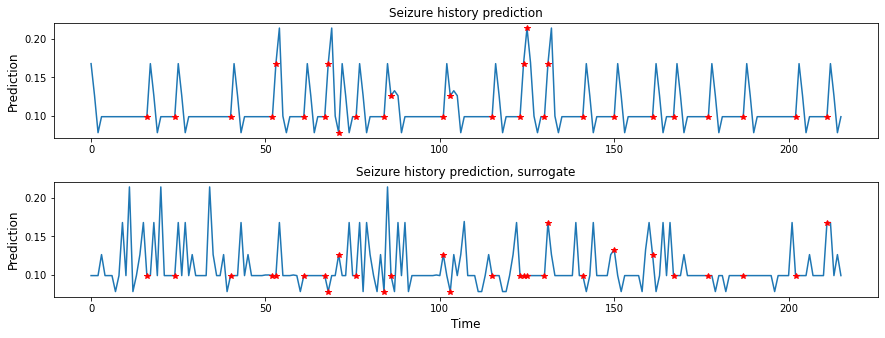

In [17]:
fig, axs = plt.subplots(2, 1,figsize=(12.4, 4.8))
axs[0].set_ylabel('Prediction',fontsize=12)
axs[0].plot(predictions_sz)
axs[0].plot(np.nonzero(seizures)[0], predictions_sz[seizures==1],'r*')
axs[0].set_title('Seizure history prediction')
axs[1].set_title('Seizure history prediction, surrogate')
axs[1].plot(predictions_sz_surro)
axs[1].plot(np.nonzero(seizures)[0], predictions_sz_surro[seizures==1],'r*')
axs[1].set_xlabel('Time',fontsize=12)
axs[1].set_ylabel('Prediction',fontsize=12)
plt.tight_layout()
plt.show();

Again, the surrogate predictions seems just as bad as the original ones.

### Surrogate ROC
We will now evaluate the ROC for the surrogates and the original one. First we compute 100 surrogates. 

In [18]:
nsurro = 100
fpr_surros, tpr_surros, auc_surros = [], [], []
for i in range(nsurro):
    fpr_IEA_su, tpr_IEA_su, _ = roc_curve(seizures, np.random.permutation(predictions_IEA))
    fpr_surros.append(fpr_IEA_su)
    tpr_surros.append(tpr_IEA_su)
    auc_surros.append(auc(fpr_IEA_su, tpr_IEA_su))

To check for statistical significance, we take the 95 percentile of the surrogates and confront it with the original prediction.

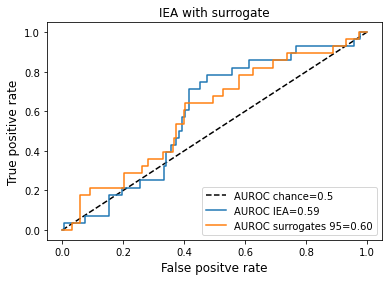

In [19]:
auc_95 = np.percentile(auc_surros, 95)
idx_95 = (np.abs(auc_surros - auc_95)).argmin()
auc_05 = np.percentile(auc_surros, 5)
idx_05 = (np.abs(auc_surros - auc_05)).argmin()

plt.figure()
plt.title('IEA with surrogate')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_IEA, tpr_IEA)
plt.plot(fpr_surros[idx_95], tpr_surros[idx_95])
plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.legend(['AUROC chance=0.5','AUROC IEA=%0.2f' % (auroc_IEA),'AUROC surrogates 95=%0.2f' % (auc_95)])
plt.show();

The 95th percentile of the surrogates have better prediction that the original prediction.

We do the same for the seizure history surrogates.

In [20]:
nsurro = 100
fpr_surros, tpr_surros, auc_surros = [], [], []
for i in range(nsurro):
    fpr_sz_su, tpr_sz_su, _ = roc_curve(seizures, np.random.permutation(predictions_sz))
    fpr_surros.append(fpr_sz_su)
    tpr_surros.append(tpr_sz_su)
    auc_surros.append(auc(fpr_sz_su, tpr_sz_su))

We again take the 95 percentile of the surrogates and confront it with the original prediction.

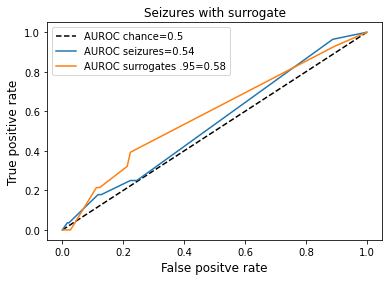

In [21]:
auc_95 = np.percentile(auc_surros, 95)
idx_95 = (np.abs(auc_surros - auc_95)).argmin()

plt.figure()
plt.title('Seizures with surrogate')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_sz, tpr_sz)
plt.plot(fpr_surros[idx_95], tpr_surros[idx_95])
plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.legend(['AUROC chance=0.5','AUROC seizures=%0.2f' % (auroc_sz),'AUROC surrogates .95=%0.2f' % (auc_95)])
plt.show();

As above, the 95th percentile of the surrogates have better prediction that the original prediction. Here it's quite clear that the surrogates have similar prediction power than the original prediction. 

### Exercice: 

Check if the multidien prediction pass the 100 surrogate test and plot the 95th along with the original prediction

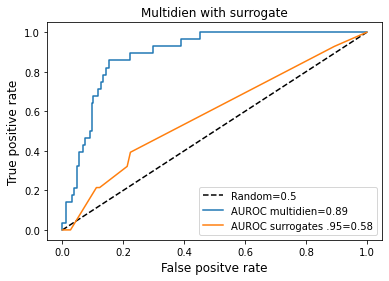

In [22]:
auc_95 = np.percentile(auc_surros, 95)
idx_95 = (np.abs(auc_surros - auc_95)).argmin()

plt.figure()
plt.title('Multidien with surrogate')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_multi, tpr_multi)
plt.plot(fpr_surros[idx_95], tpr_surros[idx_95])
plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.legend(['Random=0.5','AUROC multidien=%0.2f' % (auroc_multi),'AUROC surrogates .95=%0.2f' % (auc_95)])
plt.show();

We finally plot the AUC for the whole cohort. Take the scores for all the covariates

In [23]:
results_multi = feather.read_dataframe(r'data/all_patients_no_cross_auto_optimum_test_day_acausal4.feather')
results_sz_IEA_history = feather.read_dataframe(r'data/all_patients_optimum_test_day_acausal4.feather')

Auc_multi = results_multi[results_multi['cov_choice']=='phase_multi']['score'].to_numpy()
Auc_sz = results_sz_IEA_history[results_sz_IEA_history['cov_choice']=='only_auto']['score'].to_numpy()
Auc_IEA = results_sz_IEA_history[results_sz_IEA_history['cov_choice']=='only_cross']['score'].to_numpy()

Plot the boxplot for the covariates

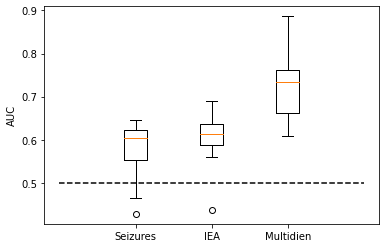

In [24]:
plt.figure
plt.boxplot([Auc_sz,Auc_IEA,Auc_multi])
plt.plot([0, 4],[0.5, 0.5],'k--')
plt.xticks(range(1,4), ['Seizures', 'IEA', 'Multidien'])
plt.ylabel('AUC')
plt.show();

## Simulations

In order to better understand the behaviour of the ROC across a range of forecasts, we simulate both the IEA and the seizures with a Poisson process. Importantly, the Poisson process is inhomogeneous and has at any moment a single rate parameter (lambda), which we choose to be periodic over time.

We first define the variables of interest:

We define the underlying rhythm as a cosinus with a fixed period of 30 days.

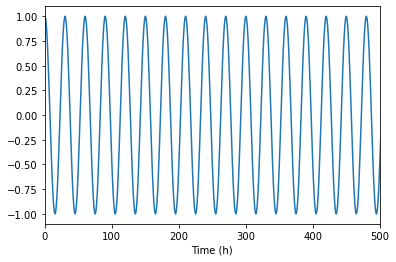

In [25]:
T = 1000
t = np.arange(0,T)
period = 30 
x = np.cos((2*np.pi/(period))*t)
plt.figure()
plt.plot(x)
plt.xlim([0, 500])
plt.xlabel('Time (h)')
plt.show();

We then generate the conditional intensity, i.e. the "true (or latent) likelihood" of seizures, that will determine the probability that a seizure is observed, and from which we will draw seizures (random realization based on this conditional intensity).

In [26]:
lambda_sz, sz = [], []
seiz_level=5.5
for ix in x:               
    lambda_sz.append(np.exp(-5.5 +  seiz_level*ix))
    p = lambda_sz[-1]
    if p > np.random.uniform():    
        sz.append(1)
    else:
        sz.append(0)
lambda_sz, sz = np.array(lambda_sz), np.array(sz)

Plot the simulated data.

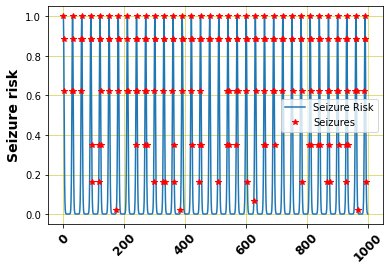

Number of seizures=181


In [27]:
plt.figure()
plt.plot(t,lambda_sz)
plt.plot(t[sz==1], lambda_sz[sz==1],'r*')
plt.ylabel('Seizure risk', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.legend(['Seizure Risk','Seizures'])
plt.show()
print('Number of seizures=%0.0f' %len(np.where(sz==1)[0]))

We can now compute the roc curve.

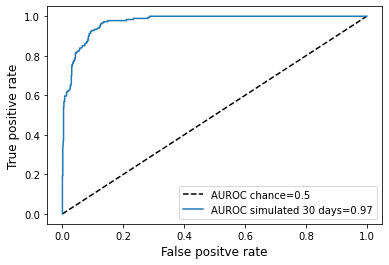

In [28]:
fpr, tpr, _ = roc_curve(sz, lambda_sz)
auroc = auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auroc))
plt.legend(['AUROC chance=0.5','AUROC simulated %0.0f days=%0.2f' %(period,auroc)])
plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.show();

### Same model, different intensity

What happens if in our model, the number of seizures are less frequent? To check this, we perform the same simulations, but now with a seiz_level = 3

Number of seizures=54


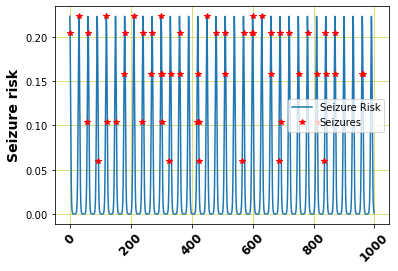

In [29]:
T = 1000
t = np.arange(0,T)
period = 30 
x = np.cos((2*np.pi/(period))*t)

lambda_sz, sz = [], []
seiz_level = 4
for ix in x:               
    lambda_sz.append(np.exp(-5.5 +  seiz_level*ix))
    p = lambda_sz[-1]
    if p > np.random.uniform():    
        sz.append(1)
    else:
        sz.append(0)
lambda_sz, sz = np.array(lambda_sz), np.array(sz)
print('Number of seizures=%0.0f' %len(np.where(sz==1)[0]))
plt.figure()
plt.plot(t,lambda_sz)
plt.plot(t[sz==1], lambda_sz[sz==1],'r*')
plt.ylabel('Seizure risk', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.legend(['Seizure Risk','Seizures'])
plt.show()

We can now plot the ROC curve:

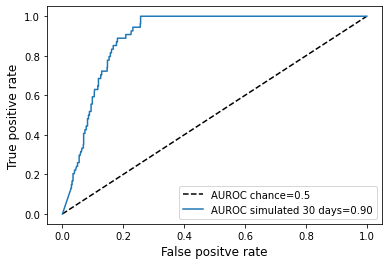

In [30]:
fpr, tpr, _ = roc_curve(sz, lambda_sz)
auroc = auc(fpr, tpr)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auroc))
plt.legend(['AUROC chance=0.5','AUROC simulated %0.0f days=%0.2f' %(period,auroc)])
plt.xlabel('False positve rate',fontsize=12)
plt.ylabel('True positive rate',fontsize=12)
plt.show();

The ROC curve is lower even if we use the true latent variable (lambda_sz) as a forecast. ROC curve thus does not account on how faithful the prediction is accurate on a probabilistic level. It only accounts for the differences on the prediction score.